# Modelo 6 Multiclase

## Importacion de librerias:

In [1]:
import os, time, datetime
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50 # type: ignore
from tensorflow.keras import layers, models # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
from tensorflow.keras.metrics import AUC, F1Score # type: ignore
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from tensorflow.keras import backend as K # type: ignore
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers.schedules import ExponentialDecay # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.regularizers import l2 # type: ignore
from tensorflow.keras.models import load_model  # type: ignore
from tensorflow.keras.callbacks import TensorBoard # type: ignore
from tensorflow.keras.datasets import cifar100 # type: ignore
from tensorflow.keras.utils import to_categorical # type: ignore

In [2]:
class ImageDataset:
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.images = []
        self.labels = []

    def load_data(self):
        for label in ['plaga', 'sana', 'otros']:  # Añadido 'otros'
            label_dir = os.path.join(self.data_dir, label)
            if not os.path.exists(label_dir):
                print(f"Advertencia: no existe la carpeta {label_dir}")
                continue
            for image_name in os.listdir(label_dir):
                img_path = os.path.join(label_dir, image_name)
                img_array = self.load_and_preprocess_image(img_path)
                if img_array is not None:
                    self.images.append(img_array)
                    self.labels.append(self.assign_label(label))

    def load_and_preprocess_image(self, img_path):
        try:
            img = load_img(img_path, target_size=(224, 224))  # Redimensionar
            img_array = img_to_array(img) / 255.0  # Normalizar
            return img_array
        except OSError as e:
            print(f"Error al cargar la imagen {img_path}: {e}")
            return None

    def assign_label(self, label):
        if label == 'plaga':
            return 0
        elif label == 'sana':
            return 1
        elif label == 'otros':
            return 2
        else:
            raise ValueError(f"Etiqueta desconocida: {label}")


In [5]:
class ResNetModel:
    def __init__(self):
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

        # Descongelar últimas 10 capas para fine-tuning
        for layer in base_model.layers[:-10]:
            layer.trainable = True

        self.model = models.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dropout(0.2),
            layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
            layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
            layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
            layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
            layers.Dense(3, activation='softmax')  # CAMBIO: 3 clases y softmax
        ])

    def compile(self):
        lr_schedule = ExponentialDecay(
            initial_learning_rate=0.001,
            decay_steps=50000,
            decay_rate=0.96,
            staircase=True
        )
        optimizer = Adam(learning_rate=lr_schedule)

        # Métricas: accuracy funciona para multiclase
        # Si tienes métricas AUC o F1 multiclase configuradas, agrégalas, sino solo accuracy
        self.model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',  # CAMBIO: pérdida para multiclase
            metrics=['accuracy']
        )

    def train(self, X_train, y_train, X_val, y_val, epochs=6, batch_size=32):
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
        log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

        print("Iniciando el entrenamiento del modelo...")
        history = self.model.fit(
            X_train,
            y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(X_val, y_val),
            callbacks=[early_stopping, tensorboard_callback],
            verbose=1
        )
        return history

    def evaluate(self, X_val, y_val):
        loss, accuracy = self.model.evaluate(X_val, y_val)
        print(f'Pérdida: {loss}, Accuracy: {accuracy}')
        return loss, accuracy

    def save(self, model_name='modelo_entrenado_resnet.h5'):
        self.model.save(model_name)

In [6]:


# Cargar tus imágenes con plaga y sanas con tu clase ImageDataset
data_dir = 'data/'  # Cambia a tu ruta local
dataset = ImageDataset(data_dir)
dataset.load_data()

images = np.array(dataset.images)  # Deben estar normalizadas y tamaño 224x224
labels = np.array(dataset.labels)  # Etiquetas 0=plaga, 1=sana, 2=otros (debes asegurarte que asignaste 2 para "otros" en tu carpeta)

# Convertir etiquetas a one-hot (3 clases)
labels_cat = to_categorical(labels, num_classes=3)

# Dividir en train y val
X_train, X_val, y_train, y_val = train_test_split(images, labels_cat, test_size=0.2, random_state=42, stratify=labels)

print("Shape X_train:", X_train.shape)  # Ejemplo: (??, 224, 224, 3)
print("Shape y_train:", y_train.shape)  # Ejemplo: (??, 3)
print("Shape X_val:", X_val.shape)
print("Shape y_val:", y_val.shape)

Shape X_train: (3740, 224, 224, 3)
Shape y_train: (3740, 3)
Shape X_val: (936, 224, 224, 3)
Shape y_val: (936, 3)


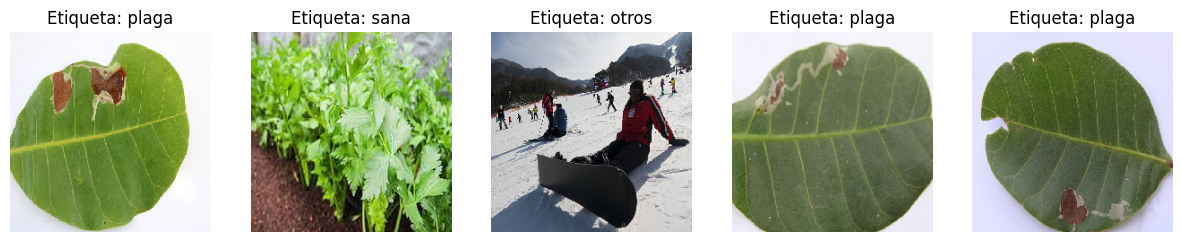

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Número de imágenes a seleccionar
num_imagenes = 5

# Seleccionar índices aleatorios sin reemplazo
indices_aleatorios = np.random.choice(len(X_val), size=num_imagenes, replace=False)

# Mostrar las imágenes seleccionadas con sus etiquetas
clases = ['plaga', 'sana', 'otros']

plt.figure(figsize=(15, 5))
for i, idx in enumerate(indices_aleatorios):
    img = X_val[idx]
    etiqueta_onehot = y_val[idx]
    etiqueta = np.argmax(etiqueta_onehot)

    plt.subplot(1, num_imagenes, i + 1)
    plt.imshow(img)
    plt.title(f"Etiqueta: {clases[etiqueta]}")
    plt.axis('off')

plt.show()

In [10]:
import numpy as np

# Ver frecuencia por clase en validación
counts = np.bincount(np.argmax(y_val, axis=1))
print("Distribución de clases en validación:", counts)


Distribución de clases en validación: [312 305 319]


In [11]:
model = ResNetModel()
model.compile()
print("Compilando el modelo...")
history = model.train(X_train, y_train, X_val, y_val, epochs=100, batch_size=32)

# Evaluar el modelo
loss, accuracy = model.evaluate(X_val, y_val)

Compilando el modelo...
Iniciando el entrenamiento del modelo...
Epoch 1/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 977s 8s/step - accuracy: 0.8162 - loss: 1.8154 - val_accuracy: 0.3333 - val_loss: 3.8514
Epoch 2/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 946s 8s/step - accuracy: 0.9267 - loss: 0.8185 - val_accuracy: 0.3408 - val_loss: 1.6627
Epoch 3/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 903s 8s/step - accuracy: 0.9515 - loss: 0.4838 - val_accuracy: 0.3333 - val_loss: 3.7036
Epoch 4/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 910s 8s/step - accuracy: 0.9449 - loss: 0.3892 - val_accuracy: 0.3408 - val_loss: 3.3031
Epoch 5/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 906s 8s/step - accuracy: 0.9579 - loss: 0.2878 - val_accuracy: 0.4274 - val_loss: 1.5229
Epoch 6/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 903s 8s/step - accuracy: 0.9646 - loss: 0.2229 - val_accuracy: 0.3632 - val_loss: 2.0220
Epoch 7/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 904s 8s/step - accuracy: 0.9611 - loss: 0.2013 - val_accuracy: 0.6538 - val_loss: 1.7509
Epoch 8/100
117/117 ━━━━━

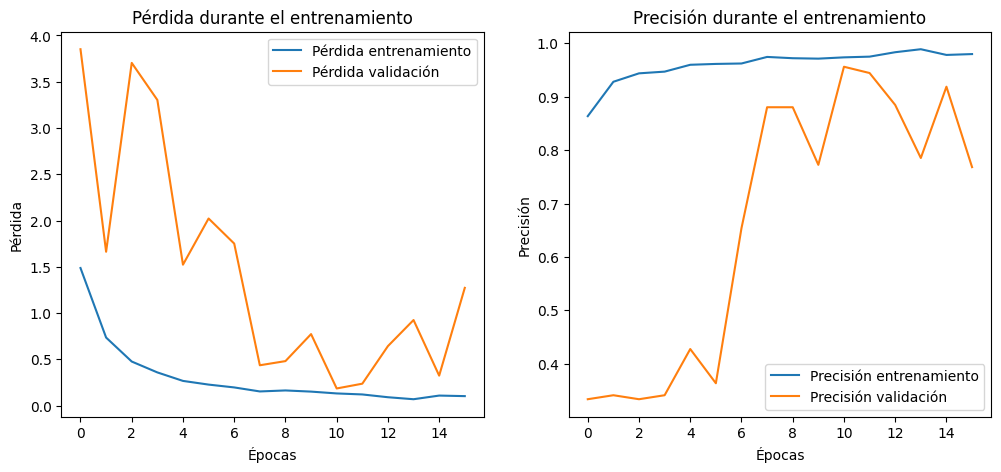

In [12]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Pérdida
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Pérdida entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida validación')
    plt.title('Pérdida durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Precisión entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Precisión validación')
    plt.title('Precisión durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()

    plt.show()

# Luego de entrenar, por ejemplo:
plot_training_history(history)


In [13]:
import numpy as np

# Predecir probabilidades
y_pred_probs = model.model.predict(X_val)

# Obtener etiquetas predichas (índice de la clase con mayor probabilidad)
y_pred = np.argmax(y_pred_probs, axis=1)

# Obtener etiquetas reales (de one-hot a etiqueta numérica)
y_true = np.argmax(y_val, axis=1)


30/30 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step


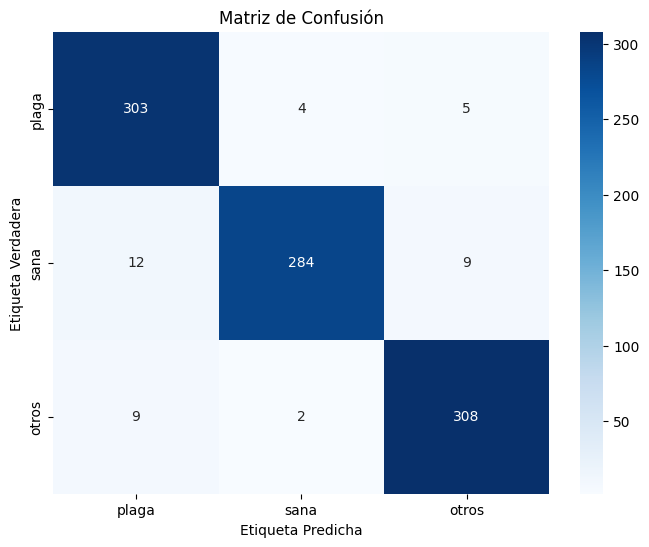

In [14]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

# Etiquetas de las clases
class_names = ['plaga', 'sana', 'otros']

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


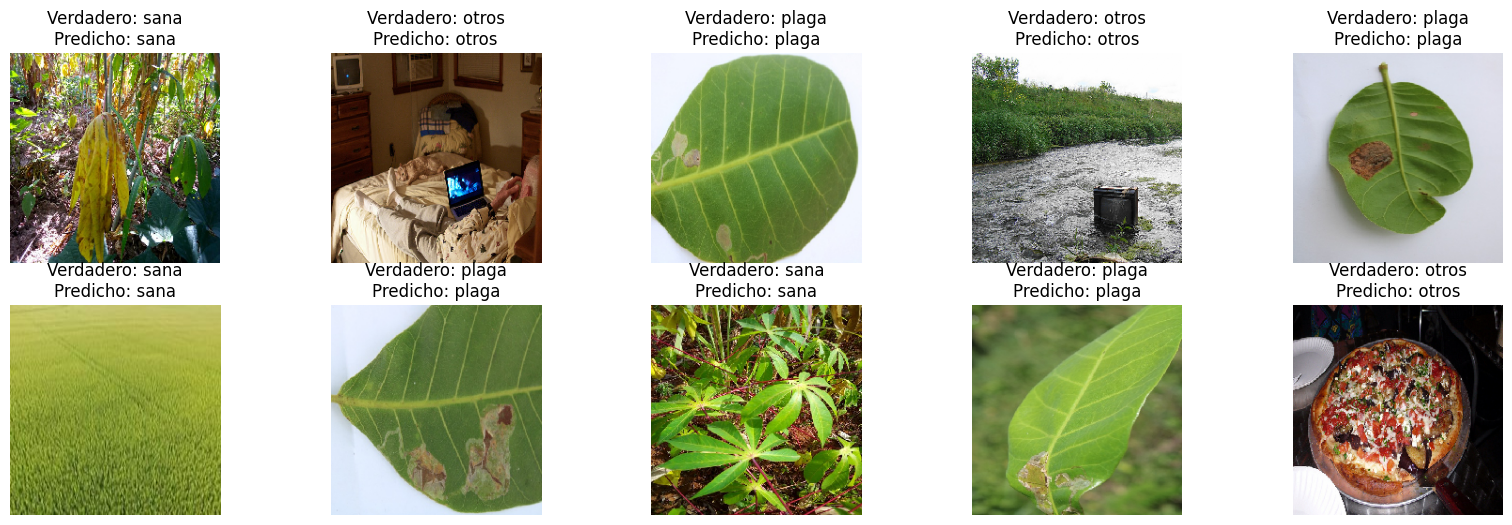

In [29]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Seleccionar 10 índices aleatorios del conjunto de validación
indices = random.sample(range(len(X_val)), 10)

# Etiquetas de las clases
class_names = ['plaga', 'sana', 'otros']

plt.figure(figsize=(20, 6))

for i, idx in enumerate(indices):
    img = X_val[idx]
    true_label = np.argmax(y_val[idx])
    
    # Expandir dims para predecir (batch=1)
    img_input = np.expand_dims(img, axis=0)
    pred_probs = model.model.predict(img_input)
    pred_label = np.argmax(pred_probs[0])
    
    # Mostrar imagen
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Verdadero: {class_names[true_label]}\nPredicho: {class_names[pred_label]}")
    
plt.show()




In [16]:
model.save('modelo_resnet_multiclase.h5')


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


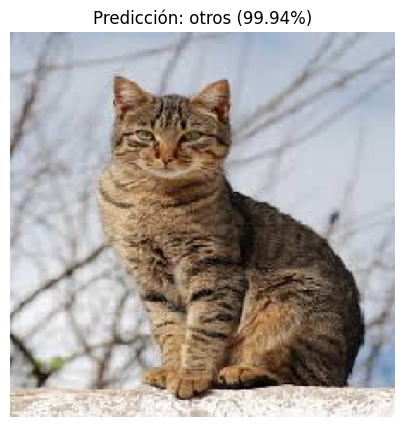

Shape de la imagen procesada: (224, 224, 3)
Predicción cruda (probabilidades): [1.6936156e-04 4.1420836e-04 9.9941635e-01]
Predicción final: otros con probabilidad 0.9994


In [30]:
from tensorflow.keras.models import load_model #type: ignore
from tensorflow.keras.preprocessing import image #type: ignore

# Carga el modelo desde el archivo .h5
modelo_cargado = load_model('modelo_resnet_multiclase.h5')

img_path = 'Otros\\images.jpg'

# Etiquetas de las clases
clases = ['plaga', 'sana', 'otros']

# 1️⃣ Cargar imagen y redimensionar
img = image.load_img(img_path, target_size=(224, 224))

# 2️⃣ Convertir imagen a array numpy
img_array = image.img_to_array(img)

# 3️⃣ Expandir dimensiones para batch y normalizar
img_array_expanded = np.expand_dims(img_array, axis=0) / 255.0

# 4️⃣ Predecir con el modelo cargado (modelo_test debe estar cargado)
prediccion = modelo_cargado.predict(img_array_expanded)

# 5️⃣ Obtener índice de la clase con mayor probabilidad
indice_clase = np.argmax(prediccion[0])

# 6️⃣ Obtener etiqueta y probabilidad
etiqueta_predicha = clases[indice_clase]
probabilidad = prediccion[0][indice_clase]

# 7️⃣ Mostrar imagen y resultado
plt.figure(figsize=(5,5))
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicción: {etiqueta_predicha} ({probabilidad:.2%})")
plt.show()

# 8️⃣ Mostrar detalles en consola
print(f"Shape de la imagen procesada: {img_array.shape}")
print(f"Predicción cruda (probabilidades): {prediccion[0]}")
print(f"Predicción final: {etiqueta_predicha} con probabilidad {probabilidad:.4f}")